## creation of the correlation between trigger capablity and physical channels - tab. 3

**This approach is based on the fact that from every app description is always possible to extrapolate the physical channel which the smartapp is trigger on.**

possible problems:
1. what happens if is not possible to extrapolate a physical channel from Samsung smartapp description?
2. if a smartapp has too many trigger capabilities, are they all correlated to only one physical channel? 

evolution:
1. save every pair of trigger-action and every smart app description
2. save the cluster of every channel
3. extrapolate from the description the physical channel which the app is trigger on, so creation of the correlation between smartapp<-->channel
4. save for every smartapp, all the trigger capability to smartapp's channel

In [19]:
from gensim.models import Word2Vec, KeyedVectors 
import json   # for read the JSON file
import stanza # Official Stanford NLP Python Library for Many Human Languages
import numpy as np

In [20]:
file = open("../1_Intra_app_Analysis/trigger-action.JSON","r") # read all the capability extrapolated from the apps
trigger_action = json.load(file)
print("tot app analysed:",len(trigger_action.keys()))

tot app analysed: 86


In [21]:
file = open("../1_Intra_app_Analysis/app-description.JSON","r") # need the desription of the analysed apps
app_description = json.load(file)

In [22]:
# as wrote in the paper "In the end, we check each cluster’s representative keyword and remove
# non-physical-channel related keywords." (cap 4.2 - p 835) so modify and use cluster_pysical_channels_FINAL
file = open("cluster_channels_FINAL.JSON","r") 
dict_channels = json.load(file)
dict_channels

{'temperature': ['air_conditioner',
  'ambient',
  'brightness',
  'heater',
  'sensor',
  'sensors',
  'temp',
  'thermostat',
  'ventilation',
  'temperature'],
 'humidity': ['ambient',
  'brightness',
  'moisture',
  'temperature',
  'thermostat',
  'ventilation',
  'weather',
  'humidity'],
 'illumination': ['appliances',
  'brightness',
  'bulbs',
  'cameras',
  'candle',
  'colors',
  'heater',
  'light',
  'lighting',
  'sirens',
  'switch',
  'switches',
  'thermostat',
  'lights'],
 'motion': ['action', 'motion'],
 'location': ['area', 'hub', 'place', 'location'],
 'smoke': ['ambient',
  'fire',
  'heater',
  'leaks',
  'temperature',
  'thermostat',
  'ventilation',
  'carbon_monoxide'],
 'leakage': ['device',
  'heater',
  'leaks',
  'lever',
  'sensor',
  'sensors',
  'switches',
  'thermostat',
  'ventilation',
  'valve',
  'weather'],
 'time': ['amount',
  'anytime',
  'day',
  'days',
  'hour',
  'minutes',
  'period',
  'place',
  'times',
  'week',
  'time'],
 'locatio

In [23]:
stanza.download('en')       # This downloads the English models for the neural pipeline
nlp = stanza.Pipeline('en') # This sets up a default neural pipeline in English
model = KeyedVectors.load_word2vec_format('../../../GoogleNews-vectors-negative300.bin', binary=True, limit=100000) # load word2vec pre-trained

2021-10-05 11:54:16 INFO: Downloading default packages for language: en (English)...
2021-10-05 11:54:17 INFO: File exists: /home/volta/stanza_resources/en/default.zip.
2021-10-05 11:54:22 INFO: Finished downloading models and saved to /home/volta/stanza_resources.
2021-10-05 11:54:22 INFO: Loading these models for language: en (English):
| Processor | Package   |
-------------------------
| tokenize  | combined  |
| pos       | combined  |
| lemma     | combined  |
| depparse  | combined  |
| sentiment | sstplus   |
| ner       | ontonotes |

2021-10-05 11:54:22 INFO: Use device: cpu
2021-10-05 11:54:22 INFO: Loading: tokenize
2021-10-05 11:54:22 INFO: Loading: pos
2021-10-05 11:54:22 INFO: Loading: lemma
2021-10-05 11:54:22 INFO: Loading: depparse
2021-10-05 11:54:23 INFO: Loading: sentiment
2021-10-05 11:54:23 INFO: Loading: ner
2021-10-05 11:54:24 INFO: Done loading processors!


In [30]:
# during the analysis of the most important keywords inside a description is better to use only singular pronoun 
# due to the fact of the NNS like lights that are very frequent inside smartapp descriptions 

POS_accepted=["NN"] # part of speech tags accepted ---> deleted: "NNS", "NNP", "NNPS"
app_to_channel = {} # dictionary made of [samsung-app]: "correlated channel".

for app in trigger_action.keys(): # analyse every samsung app
    app = "energy-alerts"
    keywords = [] # keywords found inside an app description 
    des_analysed = nlp(app_description[app])         # apply Stanford NLP to description
    for sent in des_analysed.sentences:
        for word in sent.words:                      # check each word of the description
            if word.xpos in POS_accepted:
                keyword_found = word.text.lower()    # filter: to all lowercase words
                if len(keyword_found) > 1:           # not accept symbols
                    if not keyword_found in keywords:    # if not already saved, 
                        #print(f"found word:{word.text}   \txpos: {word.xpos}\n")
                        keywords.append(keyword_found)   # add to the list of keywords

    # after finish to check the app description keywords
    clean_keywords = [] # find what words can be really processed by word2vec
    for i in range(len(keywords)):                   # for every keyword exstracted
        try:
            model[keywords[i]]                       # check Word2Vec
            clean_keywords.append(keywords[i])       # if can apply word2vec save it
        except KeyError as err:
            print("handling Error: ", err)           # some words can not be processed by Word2Vec

    print(app,"-", clean_keywords)        
    similarity_matrix = {}

    if len(clean_keywords) == 0: # case there aren't any NN keyword inside that app description (strange)
        print(f"-->app [{app}] non presenta nessun NN")

    else:
        if len(clean_keywords) == 1: # case there are only 1 NN keyword inside that app description
            for key in dict_channels.keys(): # check for every channel
                similarity_temp = 0
                for channel_NN in dict_channels[key]: # for every keyword inside the channel cluster
                    print(f"check {clean_keywords[0]} and {channel_NN}")
                    similarity_temp += model.similarity(clean_keywords[0],channel_NN)
                # divide by the number of cluster keywords --> result: the mean of similarity
                similarity_matrix[key] = (similarity_temp/len(dict_channels[key]))*100

        else: # case there are more than 1 NN keyword inside that app description
            for key in dict_channels.keys(): # check for every channel
                similarity_partial = 0
                for keyword in clean_keywords: # for every keyword NN extracted from description
                    similarity_temp = 0
                    for channel_NN in dict_channels[key]:  # for every keyword inside the channel cluster
                        #print(keyword,channel_NN,"\t", model.similarity(keyword,channel_NN))
                        similarity_temp += model.similarity(keyword,channel_NN)
                     # divide by the number of cluster keywords --> result: the mean of similarity (given by only 1 NN)
                    similarity_temp = similarity_temp/len(dict_channels[key])
                    similarity_partial += similarity_temp
                #print("this keyword for ",key,"has got a level", similarity_partial/len(clean_keywords))
                similarity_matrix[key] = (similarity_partial/len(clean_keywords))*100
        
        print(similarity_matrix)
        # now find the highest channel association 
        channel_association = ""
        max_value = 0
        for channel in similarity_matrix.keys():
            if (similarity_matrix[channel] > max_value):
                max_value = similarity_matrix[channel]
                channel_association = channel
                
        print("most similar:", channel_association, max_value)
        app_to_channel[app] = channel_association

energy-alerts - ['energy']
check energy and air_conditioner
check energy and ambient
check energy and brightness
check energy and heater
check energy and sensor
check energy and sensors
check energy and temp
check energy and thermostat
check energy and ventilation
check energy and temperature
check energy and ambient
check energy and brightness
check energy and moisture
check energy and temperature
check energy and thermostat
check energy and ventilation
check energy and weather
check energy and humidity
check energy and appliances
check energy and brightness
check energy and bulbs
check energy and cameras
check energy and candle
check energy and colors
check energy and heater
check energy and light
check energy and lighting
check energy and sirens
check energy and switch
check energy and switches
check energy and thermostat
check energy and lights
check energy and action
check energy and motion
check energy and area
check energy and hub
check energy and place
check energy and location

KeyboardInterrupt: 

In [25]:
print(len(app_to_channel))
app_to_channel

82


{'beacon-control': 'lock',
 'bon-voyage': 'locationMode',
 'brighten-dark-places': 'temperature',
 'brighten-my-path': 'motion',
 'button-controller': 'lock',
 'camera-power-scheduler': 'time',
 'carpool-notifier': 'locationMode',
 'close-the-valve': 'leakage',
 'curling-iron': 'time',
 'darken-behind-me': 'motion',
 'double-tap': 'lock',
 'dry-the-wetspot': 'humidity',
 'elder-care-daily-routine': 'time',
 'elder-care-slip-fall': 'time',
 'energy-alerts': 'humidity',
 'energy-saver': 'humidity',
 'feed-my-pet': 'time',
 'flood-alert': 'lock',
 'forgiving-security': 'time',
 'garage-door-monitor': 'lock',
 'garage-door-opener': 'lock',
 'good-night': 'motion',
 'greetings-earthling': 'locationMode',
 'habit-helper': 'time',
 'has-barkley-been-fed': 'time',
 'hub-ip-notifier': 'location',
 'humidity-alert': 'humidity',
 'it-moved': 'motion',
 'its-too-cold': 'temperature',
 'its-too-hot': 'humidity',
 'keep-me-cozy': 'locationMode',
 'keep-me-cozy-ii': 'temperature',
 'laundry-monitor':

In [14]:
# function that map the capability to string
def cap2string(capability):
    switcher = {
        'accelerationSensor': "acceleration",
        'alarm': "alarm",
        'app': "app",
        'beacon': "beacon",
        'button': "button",
        'carbonMonoxideDetector': "carbon_monoxide",
        'colorControl': "color",
        'contactSensor': "contact",
        'doorControl': "door control",
        'illuminanceMeasurement':"illumination",
        'imageCapture': "image capture",
        'location':"location",
        'momentary': "momentary",
        'motionSensor':"motion ",
        'musicPlayer': "music player",
        'powerMeter':"power",
        'presenceSensor': "presence",
        'relativeHumidityMeasurement': "relative humidity ",
        'smokeDetector': "smoke",
        'switch': "switch",
        'switchLevel': "switch level",
        'temperatureMeasurement':"temperature",
        'thermostat': "thermostat",
        'threeAxis':"three axis",
        'touchSensor':"touch",
        'valve':"valve",
        'waterSensor':"water sensor",
        'device.PetFeederShield':"pet feeder shield",
        'device.jawboneUser':"jawbone user",
        'number': "number",
        
        'lock':"lock",
        'locationMode':"locationMode",
        'sendAction':"sendAction",
        'time':"time"
    }
    return switcher.get(capability, f"capabliti not found: {capability}")

In [23]:
dict_channels_capability={"temperature":[], "humidity":[], "illumination":[], "location":[],
                          "motion":[], "smoke":[], "leakage":[]}

# this are the capability related to the system channel (so not physical channel related capabilities)
capability_not_accepted = ["app","time", "sendAction", "locationMode", "hub",
                           "lock", "button","powerMeter","device.jawboneUser", "alarm"]

for app in app_to_physical_channel.keys(): # for every analysed app
    list_of_capabilities = trigger_action[app].keys() # save the trigger capabilities 
    physical_channel_capabilities = []
    for capability in list_of_capabilities:
        if not capability in capability_not_accepted: # if is a physical channel related capability
            physical_channel_capabilities.append(capability)
    
    if len(physical_channel_capabilities) <= 2 and len(physical_channel_capabilities) != 0: # improve the alg ---> every single smartapp can be trigger on only 1 physical channel       
        for capability in physical_channel_capabilities:
            if not capability in dict_channels_capability[app_to_physical_channel[app]]: # avoid duplicate
                dict_channels_capability[app_to_physical_channel[app]].append(capability)
                print(app, " add ", capability)

beacon-control  add  beacon
bon-voyage  add  presenceSensor
brighten-dark-places  add  contactSensor
brighten-my-path  add  motionSensor
carpool-notifier  add  presenceSensor
close-the-valve  add  waterSensor
curling-iron  add  motionSensor
double-tap  add  switch
flood-alert  add  waterSensor
forgiving-security  add  contactSensor
garage-door-monitor  add  threeAxis
good-night  add  switch
humidity-alert  add  relativeHumidityMeasurement
it-moved  add  accelerationSensor
its-too-cold  add  temperatureMeasurement
its-too-hot  add  temperatureMeasurement
keep-me-cozy  add  thermostat
keep-me-cozy  add  location
laundry-monitor  add  accelerationSensor
left-it-open  add  contactSensor
mail-arrived  add  accelerationSensor
medicine-management-contact-sensor  add  contactSensor
nfc-tag-toggle  add  touchSensor
presence-change-text  add  presenceSensor
ready-for-rain  add  contactSensor
smart-security  add  motionSensor
sunrise-sunset  add  location
thermostats  add  smokeDetector
thermosta

In [24]:
dict_channels_capability

{'temperature': ['temperatureMeasurement',
  'thermostat',
  'location',
  'contactSensor',
  'motionSensor'],
 'humidity': ['presenceSensor',
  'waterSensor',
  'relativeHumidityMeasurement',
  'temperatureMeasurement',
  'contactSensor',
  'motionSensor'],
 'illumination': ['switch', 'accelerationSensor', 'location', 'contactSensor'],
 'location': ['beacon',
  'presenceSensor',
  'motionSensor',
  'contactSensor',
  'smokeDetector',
  'carbonMonoxideDetector'],
 'motion': ['motionSensor',
  'waterSensor',
  'contactSensor',
  'switch',
  'accelerationSensor',
  'presenceSensor'],
 'smoke': ['threeAxis'],
 'leakage': ['contactSensor', 'accelerationSensor', 'touchSensor']}

In [25]:
with open("set_of_capability_related_physical_channels.JSON","w") as outfile:
    json.dump(dict_channels_capability, outfile)

## analysis of the number of trigger-capability and action-capability

In [26]:
dict_actions_related={"temperature":[], "humidity":[], "illumination":[], "location":[],
                          "motion":[], "smoke":[], "leakage":[]}
dict_trigger_related={"temperature":[], "humidity":[], "illumination":[], "location":[],
                          "motion":[], "smoke":[], "leakage":[]}

for app in trigger_action.keys(): # for every app where I can extrapolate info
    if app in app_to_physical_channel.keys(): # some app description couldn't have some NN 
        physical_channel_correlated = app_to_physical_channel[app] # save the physical trigger channel of that app
        for trigger_cap in trigger_action[app].keys(): # for every trigger channel of that app
            if not trigger_cap in capability_not_accepted: # if the trigger capability is correlated to physical channel
                dict_trigger_related[physical_channel_correlated].append(trigger_cap) # save it 
                
for app in trigger_action.keys(): # for every app where I can extrapolate info
    for trigger_cap in trigger_action[app].keys(): # for every app trigger trigger capability
        if not trigger_cap in capability_not_accepted: # if trigger capability is related to physical channel
            for actions in trigger_action[app][trigger_cap]: # for every action correlated to that trigger capability
                action_capability = actions[0] # save the action capability
                if not action_capability in capability_not_accepted: # is the action capability is related to physical channel
                    for physical_channel in dict_channels_capability.keys(): # for every physical channel
                        if action_capability in dict_channels_capability[physical_channel]: # find if there is that action capability
                            dict_actions_related[physical_channel].append(action_capability) # if there is save the action capability 
dict_actions_related

{'temperature': ['thermostat',
  'thermostat',
  'thermostat',
  'thermostat',
  'thermostat',
  'thermostat',
  'thermostat',
  'thermostat',
  'thermostat',
  'thermostat',
  'thermostat',
  'thermostat',
  'thermostat',
  'thermostat',
  'thermostat',
  'thermostat',
  'thermostat',
  'thermostat'],
 'humidity': [],
 'illumination': ['switch',
  'switch',
  'switch',
  'switch',
  'switch',
  'switch',
  'switch',
  'switch',
  'switch',
  'switch',
  'switch',
  'switch',
  'switch',
  'switch',
  'switch',
  'switch',
  'switch',
  'switch',
  'switch',
  'switch',
  'switch',
  'switch',
  'switch',
  'switch',
  'switch',
  'switch',
  'switch',
  'switch',
  'switch',
  'switch',
  'switch',
  'switch',
  'switch',
  'switch',
  'switch',
  'switch',
  'switch',
  'switch',
  'switch',
  'switch',
  'switch',
  'switch',
  'switch',
  'switch',
  'switch',
  'switch',
  'switch',
  'switch',
  'switch',
  'switch',
  'switch',
  'switch',
  'switch',
  'switch',
  'switch',
  '

In [27]:
action_related = []
for key in dict_actions_related.keys():
    action_related.append(len(dict_actions_related[key]))
action_related = np.array(action_related)
action_related

array([18,  0, 61,  0, 61,  0,  0])

In [28]:
trigger_related = []
for key in dict_trigger_related.keys():
    trigger_related.append(len(dict_trigger_related[key]))
trigger_related = np.array(trigger_related)
trigger_related

array([14, 16,  7, 20, 30,  1,  9])

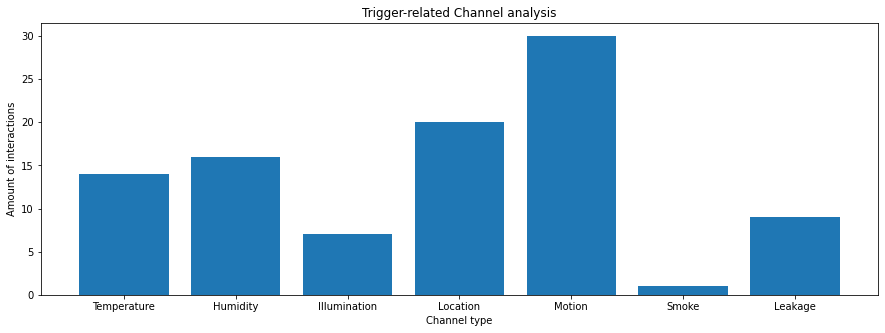

In [29]:
import matplotlib.pyplot as plt

x = ["Temperature","Humidity", "Illumination", "Location", "Motion", "Smoke", "Leakage" ]
x_pos = np.arange(len(x))
plt.figure(figsize=[15, 5])
plt.bar(x_pos, trigger_related, align='center')
plt.xticks(x_pos, x)
plt.ylabel('Amount of interactions')
plt.xlabel('Channel type')
plt.title('Trigger-related Channel analysis')
plt.show()

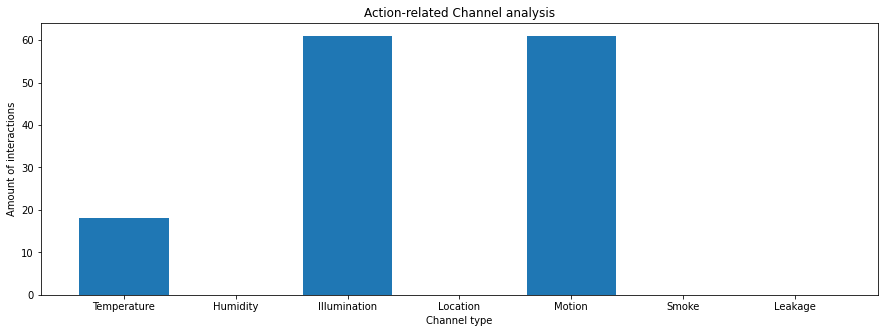

In [30]:
x_pos = np.arange(len(x))
plt.figure(figsize=[15, 5])
plt.bar(x_pos, action_related, align='center')
plt.xticks(x_pos, x)
plt.ylabel('Amount of interactions')
plt.xlabel('Channel type')
plt.title('Action-related Channel analysis')
plt.show()